In [4]:
from nDTomo.sim.shapes.phantoms import SheppLogan
from nDTomo.utils.misc import showim
from nDTomo.ct.conv_tomo import fbpvol, sinocentering

from nDTomo.nn.models_tf import DCNN2D, DnCNN, recnet, recnet_single, recnet_single_conv
from nDTomo.nn.utils_tf import tf_gpu_devices, tf_gpu_allocateRAM, ReduceLROnPlateau_custom
from nDTomo.nn.tomo_tf import tf_create_angles, tf_tomo_transf, tf_tomo_radon, tf_tomo_squeeze, tf_tomo_bp, tf_filt2D, tf_tomo_fbp, tf_mask_circle
from nDTomo.nn.losses_tf import ssim_mae_loss

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import time, h5py
from skimage.transform import radon, iradon, rotate
from skimage.transform import rescale, resize
from scipy.interpolate import interp1d
import tensorflow as tf
import tensorflow_addons as tfa
import os 

# os.environ["CUDA_VISIBLE_DEVICES"] = "1"

tf_gpu_devices()

physical_devices = tf.config.list_physical_devices('GPU') 
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

Default GPU Device:/device:GPU:0


Let's create a Shepp-Logan phantom

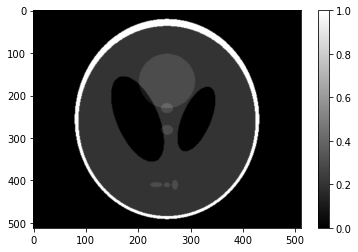

In [5]:
npix = 512
im = SheppLogan(npix)*1

showim(im, 1, cmap = 'gray')


Calculate the radon transform or sinogram

(1, 512, 512, 1)
(1, 128, 512, 1)


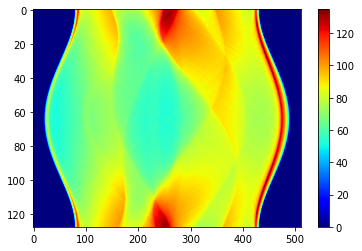

In [6]:
nproj = npix/4
theta = tf_create_angles(nproj)

imtf = tf_tomo_transf(im)
print(imtf.shape)

sino = tf_tomo_radon(imtf, theta, interp_method='bilinear')
print(sino.shape)

showim(tf_tomo_squeeze(sino), 2)

Reconstruct using the filtered back projection algorithm

256.49999999999966
The dimensions of the reconstructed volume are  (512, 512)


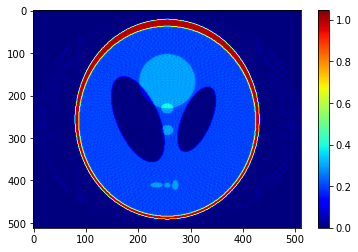

In [7]:
s = np.array(sino[0,:,:,0]).transpose()
s = sinocentering(s, 5)

fbp = fbpvol(s, theta=np.rad2deg(theta), nt = im.shape[0])
showim(fbp, 3, clim=(0, np.max(fbp)))